In [1]:
!pip install mne

In [2]:
!pip install PyWavelets

In [3]:
import mne

In [4]:
import numpy as np
import pandas as pd

In [5]:
import pywt

In [6]:
from pywt import wavedec

In [7]:
raw = mne.io.read_raw_edf("2-3.edf", preload=True)

Extracting EDF parameters from /home/xilinx/jupyter_notebooks/2-3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 307199  =      0.000 ...   599.998 secs...


In [8]:
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fz, Cz, C3, C4, Pz, Cam-Sync, PVT, EOG-V, EOG-H, EMG, ECG
 chs: 11 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2014-11-27 12:19:13 UTC
 nchan: 11
 projs: []
 sfreq: 512.0 Hz
>

In [9]:
# Sélectionner les 5 premiers canaux EEG
r=raw.pick_channels(raw.ch_names[:5])

In [10]:
print(r.info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fz, Cz, C3, C4, Pz
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2014-11-27 12:19:13 UTC
 nchan: 5
 projs: []
 sfreq: 512.0 Hz
>


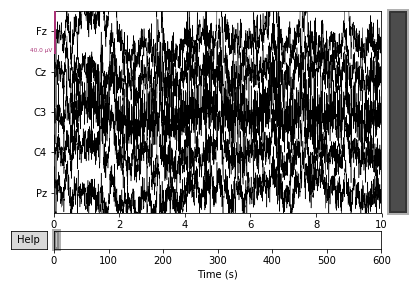

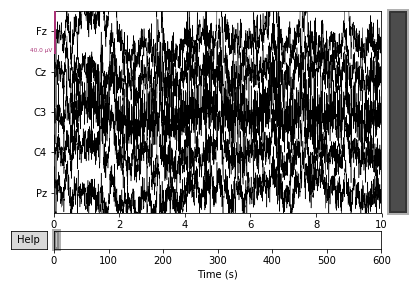

In [12]:
r.plot()

In [13]:
%%time
rf = r.filter(0.1,30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16897 samples (33.002 sec)

CPU times: user 5.64 s, sys: 493 ms, total: 6.13 s
Wall time: 6.71 s


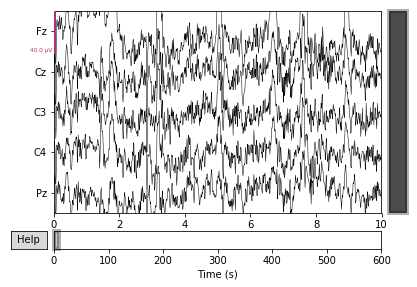

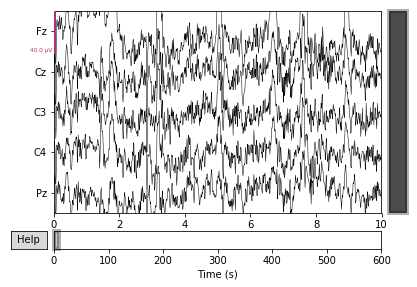

In [14]:
rf.plot()

In [15]:
print(rf.info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fz, Cz, C3, C4, Pz
 chs: 5 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 30.0 Hz
 meas_date: 2014-11-27 12:19:13 UTC
 nchan: 5
 projs: []
 sfreq: 512.0 Hz
>


In [16]:
selected_channel_name = rf.info['ch_names']
sample_frequency = rf.info['sfreq']
epoch_duration = 10

In [17]:
selected_channel_name

['Fz', 'Cz', 'C3', 'C4', 'Pz']

In [18]:
sample_frequency

512.0

In [19]:
epoch_samples = int(epoch_duration*sample_frequency)

In [20]:
epoch_samples

5120

In [21]:
total_epochs = 307200// epoch_samples

In [22]:
total_epochs

60

In [23]:
epochs_matrix = np.zeros((total_epochs, 5, epoch_samples))  # 5 channels

In [24]:
# Segmenter les données en epochs de 10 secondes
events = mne.make_fixed_length_events(rf, duration=epoch_duration)

In [25]:
# Créer un objet Epochs
epochs = mne.Epochs(rf, events, tmin=0, tmax=epoch_duration, baseline=None, detrend=1)

Not setting metadata
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


In [26]:
# Obtenir les données des epochs sous forme de tableau numpy
epochs_data = epochs.get_data()

Loading data for 60 events and 5121 original time points ...
1 bad epochs dropped


In [27]:
# Vérifier la forme de la matrice d'epochs
print("Forme de la matrice d'epochs:", epochs_data.shape)

Forme de la matrice d'epochs: (59, 5, 5121)


In [28]:
!pip install scipy

In [29]:
import scipy.stats as stats

In [30]:
zscores = stats.zscore(epochs_data)

In [31]:
zscores.shape

(59, 5, 5121)

In [32]:
# Définition de la famille d'ondelettes à utiliser
wavelet = 'db4'

# Initialisation des tableaux pour stocker les caractéristiques
cD_Energy = np.zeros((59, 5))
cA_Energy = np.zeros((59, 5))
D_Entropy = np.zeros((59, 5))
A_Entropy = np.zeros((59, 5))
D_mean = np.zeros((59, 5))
A_mean = np.zeros((59, 5))
D_std = np.zeros((59, 5))
A_std = np.zeros((59, 5))

In [33]:
%%time
for i in range(59):
  for j in range(5):
    coeffs = pywt.wavedec(zscores[i, j, :], wavelet)  # Calcul de la DWT avec pywt
    cD_Energy[i,j] = np.mean([np.sum(np.square(coeffs[5])),np.sum(np.square(coeffs[4])),
                         np.sum(np.square(coeffs[3])),np.sum(np.square(coeffs[2])),
                         np.sum(np.square(coeffs[1]))])
    cA_Energy[i,j] = np.sum(np.square(coeffs[0]))
    D_Entropy[i,j] = np.mean([np.sum(np.square(coeffs[5]) * np.log(np.square(coeffs[5]))),
                         np.sum(np.square(coeffs[4]) * np.log(np.square(coeffs[4]))),
                         np.sum(np.square(coeffs[3]) * np.log(np.square(coeffs[3]))),
                         np.sum(np.square(coeffs[2]) * np.log(np.square(coeffs[2]))),
                         np.sum(np.square(coeffs[1]) * np.log(np.square(coeffs[1])))])
    A_Entropy[i,j] = np.sum(np.square(coeffs[0]) * np.log(np.square(coeffs[0])))
    D_mean[i,j] = np.mean([np.mean(coeffs[5]),np.mean(coeffs[4]),np.mean(coeffs[3]),np.mean(coeffs[2]),np.mean(coeffs[1])])
    A_mean[i,j] = np.mean(coeffs[0])
    D_std[i,j] = np.mean([np.std(coeffs[5]),np.std(coeffs[4]),np.std(coeffs[3]),np.std(coeffs[2]),np.std(coeffs[1])])
    A_std[i,j] = np.std(coeffs[0])

CPU times: user 3.05 s, sys: 0 ns, total: 3.05 s
Wall time: 3.05 s


In [34]:
df = pd.DataFrame(cD_Energy)
df1 = pd.DataFrame(cA_Energy)
df2 = pd.DataFrame(D_Entropy)
df3 = pd.DataFrame(A_Entropy)
df4 = pd.DataFrame(D_mean)
df5 = pd.DataFrame(A_mean)
df6 = pd.DataFrame(D_std)
df7 = pd.DataFrame(A_std)

In [35]:
ddd = pd.concat([df,df1,df2,df3,df4,df5,df6,df7], axis = 1)

In [36]:
ddd

,0,1,2,3,4,0,1,2,3,4,...,0,1,2,3,4,0,1,2,3,4
0,957.034799,775.102368,790.560292,744.050559,617.329216,2563.942439,2192.660360,870.978675,1396.751948,5961.653776,...,5.084403,4.420449,4.547961,4.330785,3.786896,11.501623,11.264955,7.332290,9.257418,17.377982
1,1391.195429,950.257503,1158.977732,1084.506731,715.523709,9885.648073,9122.336710,8569.645915,6897.547469,4527.882450,...,6.003526,4.913064,5.461877,5.239791,4.163645,24.164116,21.955114,22.372708,19.502188,14.663038
2,1156.606580,893.790465,969.635004,864.282789,663.792319,35378.260547,17310.377262,20720.546012,13847.579639,6315.571689,...,5.465272,4.707237,5.017133,4.576381,3.828493,38.944822,27.499526,29.864992,25.372681,17.448241
3,1346.185606,885.304037,993.539438,968.471517,611.841100,3560.831681,2434.668457,3371.564774,4379.107084,2872.877844,...,5.695479,4.588676,4.745461,4.923728,3.854357,13.220035,11.538905,13.533972,14.138116,12.416271
4,1145.267544,834.065302,980.730150,825.622069,653.438329,1382.337347,1945.479288,2380.279456,1714.876121,3200.231636,...,5.426864,4.512870,5.020149,4.548239,3.945722,9.293883,10.800955,11.057507,10.012828,13.779249
5,1395.341667,885.180744,1006.848417,901.825019,707.939594,1333.013556,1925.785708,1839.785325,2574.026253,2283.876451,...,5.909334,4.574228,4.998433,4.615211,4.078539,9.127497,10.734648,10.573421,12.662540,11.940346
6,803.067134,643.038172,676.649860,730.558444,571.458904,1212.967830,2011.428385,1180.333699,3781.949069,3267.730300,...,4.444746,3.850095,3.963193,4.153158,3.576113,8.632773,10.665413,8.367865,15.071126,13.324842
7,791.810401,756.260550,693.067201,796.804524,743.501221,1237.200894,4549.559416,1225.808543,6964.738615,6794.591032,...,4.402948,4.280216,4.058515,4.491119,4.370733,8.210194,14.319070,8.461102,17.645408,17.245899
8,1236.460307,870.617272,981.446667,968.067609,696.587589,1343.296097,1320.836443,1949.173519,1297.906426,806.421115,...,5.593918,4.722390,4.944288,4.927693,4.160645,8.950922,8.857011,10.655567,8.359789,6.801785
9,813.432672,774.414520,718.774640,736.449437,708.042187,4099.017204,4431.824705,6609.568620,3421.553998,3254.941171,...,4.512714,4.399392,4.222118,4.261828,4.265454,14.475235,15.835686,18.152049,13.650782,14.213918


In [37]:
dddd = np.array(ddd)
head = np.array(['stage','cD_energy_fz','cD_energy_cz','cD_energy_c3','cD_energy_c4','cD_energy_pz','cA_energy_fz','cA_energy_cz','cA_energy_c3','cA_energy_c4','cA_energy_pz','D_entropy_fz','D_entropy_cz','D_entropy_c3','D_entropy_c4','D_entropy_pz','A_entropy_fz','A_entropy_cz','A_entropy_c3','A_entropy_c4','A_entropy_pz','D_mean_fz','D_mean_cz','D_mean_c3','D_mean_c4','D_mean_pz','A_mean_fz','A_mean_cz','A_mean_c3','A_mean_c4','A_mean_pz','D_std_fz','D_std_cz','D_std_c3','D_std_c4','D_std_pz','A_std_fz','A_std_cz','A_std_c3','A_std_c4','A_std_pz'])

In [38]:
rr = pd.DataFrame(dddd)
rr

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,957.034799,775.102368,790.560292,744.050559,617.329216,2563.942439,2192.660360,870.978675,1396.751948,5961.653776,...,5.084403,4.420449,4.547961,4.330785,3.786896,11.501623,11.264955,7.332290,9.257418,17.377982
1,1391.195429,950.257503,1158.977732,1084.506731,715.523709,9885.648073,9122.336710,8569.645915,6897.547469,4527.882450,...,6.003526,4.913064,5.461877,5.239791,4.163645,24.164116,21.955114,22.372708,19.502188,14.663038
2,1156.606580,893.790465,969.635004,864.282789,663.792319,35378.260547,17310.377262,20720.546012,13847.579639,6315.571689,...,5.465272,4.707237,5.017133,4.576381,3.828493,38.944822,27.499526,29.864992,25.372681,17.448241
3,1346.185606,885.304037,993.539438,968.471517,611.841100,3560.831681,2434.668457,3371.564774,4379.107084,2872.877844,...,5.695479,4.588676,4.745461,4.923728,3.854357,13.220035,11.538905,13.533972,14.138116,12.416271
4,1145.267544,834.065302,980.730150,825.622069,653.438329,1382.337347,1945.479288,2380.279456,1714.876121,3200.231636,...,5.426864,4.512870,5.020149,4.548239,3.945722,9.293883,10.800955,11.057507,10.012828,13.779249
5,1395.341667,885.180744,1006.848417,901.825019,707.939594,1333.013556,1925.785708,1839.785325,2574.026253,2283.876451,...,5.909334,4.574228,4.998433,4.615211,4.078539,9.127497,10.734648,10.573421,12.662540,11.940346
6,803.067134,643.038172,676.649860,730.558444,571.458904,1212.967830,2011.428385,1180.333699,3781.949069,3267.730300,...,4.444746,3.850095,3.963193,4.153158,3.576113,8.632773,10.665413,8.367865,15.071126,13.324842
7,791.810401,756.260550,693.067201,796.804524,743.501221,1237.200894,4549.559416,1225.808543,6964.738615,6794.591032,...,4.402948,4.280216,4.058515,4.491119,4.370733,8.210194,14.319070,8.461102,17.645408,17.245899
8,1236.460307,870.617272,981.446667,968.067609,696.587589,1343.296097,1320.836443,1949.173519,1297.906426,806.421115,...,5.593918,4.722390,4.944288,4.927693,4.160645,8.950922,8.857011,10.655567,8.359789,6.801785
9,813.432672,774.414520,718.774640,736.449437,708.042187,4099.017204,4431.824705,6609.568620,3421.553998,3254.941171,...,4.512714,4.399392,4.222118,4.261828,4.265454,14.475235,15.835686,18.152049,13.650782,14.213918


In [111]:
idx = 0
new_col = ['2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2','2']
rr.insert(loc=idx, column='stage', value=new_col)

In [112]:
print(rr)

   stage            0            1            2            3           4  \
0      2   957.034799   775.102368   790.560292   744.050559  617.329216   
1      2  1391.195429   950.257503  1158.977732  1084.506731  715.523709   
2      2  1156.606580   893.790465   969.635004   864.282789  663.792319   
3      2  1346.185606   885.304037   993.539438   968.471517  611.841100   
4      2  1145.267544   834.065302   980.730150   825.622069  653.438329   
5      2  1395.341667   885.180744  1006.848417   901.825019  707.939594   
6      2   803.067134   643.038172   676.649860   730.558444  571.458904   
7      2   791.810401   756.260550   693.067201   796.804524  743.501221   
8      2  1236.460307   870.617272   981.446667   968.067609  696.587589   
9      2   813.432672   774.414520   718.774640   736.449437  708.042187   
10     2  1447.903204  1025.134142  1321.155065   892.492589  831.554253   
11     2  1023.569391   714.397499   730.505328   955.260115  590.620956   
12     2   8

In [113]:
rr.to_csv('2-3dwt.csv',index=False,header=head)

In [114]:
sig = pd.read_csv('2-3dwt.csv')
print(sig)

    stage  cD_energy_fz  cD_energy_cz  cD_energy_c3  cD_energy_c4  \
0       2    957.034799    775.102368    790.560292    744.050559   
1       2   1391.195429    950.257503   1158.977732   1084.506731   
2       2   1156.606580    893.790465    969.635004    864.282789   
3       2   1346.185606    885.304037    993.539438    968.471517   
4       2   1145.267544    834.065302    980.730150    825.622069   
5       2   1395.341667    885.180744   1006.848417    901.825019   
6       2    803.067134    643.038172    676.649860    730.558444   
7       2    791.810401    756.260550    693.067201    796.804524   
8       2   1236.460307    870.617272    981.446667    968.067609   
9       2    813.432672    774.414520    718.774640    736.449437   
10      2   1447.903204   1025.134142   1321.155065    892.492589   
11      2   1023.569391    714.397499    730.505328    955.260115   
12      2    893.169708    855.186468    750.881239    942.075844   
13      2   1108.946080    928.457

In [115]:
p1 = '2-1dwt.csv'
p2 = '2-2dwt.csv'
p3 = '2-3dwt.csv'

In [117]:
# set files path
p1 =  '2-1dwt.csv'
p2 =  '2-2dwt.csv'
p3 =  '2-3dwt.csv'
#p4 =  '/content/8all.csv'
#p5 =  '/content/6all.csv'
#p6 =  '/content/8all.csv'
#p7 =  '/content/11all.csv'                               #'/content/drive/MyDrive/sujet4.csv'
#p8 = '/content/14all.csv'

#print("*** Merging multiple csv files into a single pandas dataframe ***")

# merge files
sujet = pd.concat(
   map(pd.read_csv, [p1,p2,p3]), ignore_index=True)
print(sujet)

     stage  cD_energy_fz  cD_energy_cz  cD_energy_c3  cD_energy_c4  \
0        1    764.673220    779.692307    975.890322    622.059868   
1        1    592.222861    637.694155    615.102983    548.470789   
2        1    885.459683    716.102291    723.614047    620.985367   
3        1    701.791291    708.285753    778.472375    620.212351   
4        1   1181.480840    720.949590    912.678826    625.722184   
5        1    821.627716    753.831692    801.597803    679.121353   
6        1    532.996528    562.408105    551.888326    451.312541   
7        1    656.802417    532.979753    484.345578    457.469456   
8        1   1150.342599    892.639771    876.266986    846.879732   
9        1    406.369360    612.812869    492.360675    448.356805   
10       1    722.086403    697.484512    752.352068    527.821025   
11       1    975.201880    819.017779    855.443461    618.702707   
12       1    703.251133    676.264603    594.724164    526.512827   
13       1    962.35

In [118]:
sujet.to_csv('2dwt.csv', index=False)

In [119]:
s = pd.read_csv('2dwt.csv')

In [120]:
print(s)

     stage  cD_energy_fz  cD_energy_cz  cD_energy_c3  cD_energy_c4  \
0        1    764.673220    779.692307    975.890322    622.059868   
1        1    592.222861    637.694155    615.102983    548.470789   
2        1    885.459683    716.102291    723.614047    620.985367   
3        1    701.791291    708.285753    778.472375    620.212351   
4        1   1181.480840    720.949590    912.678826    625.722184   
5        1    821.627716    753.831692    801.597803    679.121353   
6        1    532.996528    562.408105    551.888326    451.312541   
7        1    656.802417    532.979753    484.345578    457.469456   
8        1   1150.342599    892.639771    876.266986    846.879732   
9        1    406.369360    612.812869    492.360675    448.356805   
10       1    722.086403    697.484512    752.352068    527.821025   
11       1    975.201880    819.017779    855.443461    618.702707   
12       1    703.251133    676.264603    594.724164    526.512827   
13       1    962.35

In [39]:
data = '2_balanceddwt.csv'



df = pd.read_csv(data)

In [40]:
# view dimensions of dataset

df.shape

(236, 41)

In [41]:
df.head(5)

,stage,cD_energy_fz,cD_energy_cz,cD_energy_c3,cD_energy_c4,cD_energy_pz,cA_energy_fz,cA_energy_cz,cA_energy_c3,cA_energy_c4,...,D_std_fz,D_std_cz,D_std_c3,D_std_c4,D_std_pz,A_std_fz,A_std_cz,A_std_c3,A_std_c4,A_std_pz
0,2,1109.407946,880.751251,883.827117,994.542455,898.630745,6952.944387,13966.925448,9938.635945,12932.149906,...,5.275740,4.681700,4.738516,5.055845,4.795414,18.028276,25.326703,21.491885,24.121750,23.614193
1,2,1105.162221,998.659008,802.929089,1515.189895,1186.827678,1865.721697,1805.885222,1411.354433,1313.676804,...,5.121830,5.050114,4.233409,6.384769,5.684662,9.971223,10.083407,9.363703,8.943790,10.207700
2,2,1076.429708,731.421017,827.018233,695.231203,681.706431,1543.547333,2449.350759,3769.303333,1803.393844,...,5.227737,4.297440,4.632787,4.173055,4.172803,9.136651,12.315346,14.114708,10.003139,13.963729
3,2,1315.093416,803.143370,782.695060,1175.171385,695.051043,4458.833486,5197.166857,4740.093890,7459.248338,...,5.794019,4.257377,4.459664,5.440588,4.091881,13.870200,15.309968,14.732664,17.882203,19.538695
4,2,1476.382985,948.177788,1078.705680,854.358576,726.896906,2129.238984,1703.087664,2197.083454,1082.385411,...,5.987802,4.744602,5.056863,4.638901,4.234332,10.915505,10.306033,11.689381,7.714555,8.377358


In [42]:
# check distribution of target_class column

df['stage'].value_counts()

2    118
1    118
Name: stage, dtype: int64

In [43]:
# view the percentage distribution of target_class column

df['stage'].value_counts()/np.float(len(df))

2    0.5
1    0.5
Name: stage, dtype: float64

In [ ]:
!pip install sklearn

  Preparing metadata (setup.py) ... error
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python3.6 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-__3_6xpp/sklearn_4e89a456803e47f7a0f8bfd9344d8c34/setup.py'"'"'; __file__='"'"'/tmp/pip-install-__3_6xpp/sklearn_4e89a456803e47f7a0f8bfd9344d8c34/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-iheeel0e
       cwd: /tmp/pip-install-__3_6xpp/sklearn_4e89a456803e47f7a0f8bfd9344d8c34/
  Complete output (15 lines):
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip i

  Preparing metadata (setup.py) ... error
  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python3.6 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-__3_6xpp/sklearn_22373401f9464e8f9397abee8b77ef16/setup.py'"'"'; __file__='"'"'/tmp/pip-install-__3_6xpp/sklearn_22373401f9464e8f9397abee8b77ef16/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-pfx6rvu8
       cwd: /tmp/pip-install-__3_6xpp/sklearn_22373401f9464e8f9397abee8b77ef16/
  Complete output (18 lines):
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip i

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 7.5 MB 104 kB/s            
  Preparing metadata (setup.py) ... done
  Using cached joblib-1.1.1-py2.py3-none-any.whl (309 kB)
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=2397 sha256=503379a051e8e0f890378033937c10c557050679316c344e2ed9e978033b02b9
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c

In [44]:
# view summary of dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 41 columns):
stage           236 non-null int64
cD_energy_fz    236 non-null float64
cD_energy_cz    236 non-null float64
cD_energy_c3    236 non-null float64
cD_energy_c4    236 non-null float64
cD_energy_pz    236 non-null float64
cA_energy_fz    236 non-null float64
cA_energy_cz    236 non-null float64
cA_energy_c3    236 non-null float64
cA_energy_c4    236 non-null float64
cA_energy_pz    236 non-null float64
D_entropy_fz    236 non-null float64
D_entropy_cz    236 non-null float64
D_entropy_c3    236 non-null float64
D_entropy_c4    236 non-null float64
D_entropy_pz    236 non-null float64
A_entropy_fz    236 non-null float64
A_entropy_cz    236 non-null float64
A_entropy_c3    236 non-null float64
A_entropy_c4    236 non-null float64
A_entropy_pz    236 non-null float64
D_mean_fz       236 non-null float64
D_mean_cz       236 non-null float64
D_mean_c3       236 non-null float64
D_mean_c4

In [45]:
# check for missing values in variables

df.isnull().sum()

stage           0
cD_energy_fz    0
cD_energy_cz    0
cD_energy_c3    0
cD_energy_c4    0
cD_energy_pz    0
cA_energy_fz    0
cA_energy_cz    0
cA_energy_c3    0
cA_energy_c4    0
cA_energy_pz    0
D_entropy_fz    0
D_entropy_cz    0
D_entropy_c3    0
D_entropy_c4    0
D_entropy_pz    0
A_entropy_fz    0
A_entropy_cz    0
A_entropy_c3    0
A_entropy_c4    0
A_entropy_pz    0
D_mean_fz       0
D_mean_cz       0
D_mean_c3       0
D_mean_c4       0
D_mean_pz       0
A_mean_fz       0
A_mean_cz       0
A_mean_c3       0
A_mean_c4       0
A_mean_pz       0
D_std_fz        0
D_std_cz        0
D_std_c3        0
D_std_c4        0
D_std_pz        0
A_std_fz        0
A_std_cz        0
A_std_c3        0
A_std_c4        0
A_std_pz        0
dtype: int64

In [46]:
X = df.drop(['stage'], axis=1)

y = df['stage']

In [47]:
X

,cD_energy_fz,cD_energy_cz,cD_energy_c3,cD_energy_c4,cD_energy_pz,cA_energy_fz,cA_energy_cz,cA_energy_c3,cA_energy_c4,cA_energy_pz,...,D_std_fz,D_std_cz,D_std_c3,D_std_c4,D_std_pz,A_std_fz,A_std_cz,A_std_c3,A_std_c4,A_std_pz
0,1109.407946,880.751251,883.827117,994.542455,898.630745,6952.944387,13966.925448,9938.635945,12932.149906,12439.833588,...,5.275740,4.681700,4.738516,5.055845,4.795414,18.028276,25.326703,21.491885,24.121750,23.614193
1,1105.162221,998.659008,802.929089,1515.189895,1186.827678,1865.721697,1805.885222,1411.354433,1313.676804,1875.437295,...,5.121830,5.050114,4.233409,6.384769,5.684662,9.971223,10.083407,9.363703,8.943790,10.207700
2,1076.429708,731.421017,827.018233,695.231203,681.706431,1543.547333,2449.350759,3769.303333,1803.393844,3134.147373,...,5.227737,4.297440,4.632787,4.173055,4.172803,9.136651,12.315346,14.114708,10.003139,13.963729
3,1315.093416,803.143370,782.695060,1175.171385,695.051043,4458.833486,5197.166857,4740.093890,7459.248338,8451.967684,...,5.794019,4.257377,4.459664,5.440588,4.091881,13.870200,15.309968,14.732664,17.882203,19.538695
4,1476.382985,948.177788,1078.705680,854.358576,726.896906,2129.238984,1703.087664,2197.083454,1082.385411,1123.922430,...,5.987802,4.744602,5.056863,4.638901,4.234332,10.915505,10.306033,11.689381,7.714555,8.377358
5,1028.161377,830.384502,744.876103,793.610653,671.868076,4945.273388,2841.457750,5234.522763,2288.412854,2025.688055,...,4.999751,4.433805,4.212438,4.382098,3.879661,14.235344,11.672782,15.042107,10.128587,11.180339
6,1158.330951,785.789388,761.060093,924.395694,789.530690,763.440002,4335.884748,2442.198073,1486.773684,10867.495133,...,5.240955,4.282585,4.198514,4.682464,4.417572,6.892318,13.743113,10.932610,8.942607,20.968576
7,1358.240763,905.519431,1021.184555,1000.913035,800.711635,1515.699308,2339.974677,1365.293314,1223.041928,3086.394678,...,5.886032,4.703491,5.063605,5.043471,4.446425,9.643846,10.234943,9.222806,7.645146,11.385627
8,931.962391,727.675527,675.373367,755.490418,697.150544,5711.018152,3318.560038,4698.104048,3709.779353,1078.734087,...,4.378217,3.961688,3.636853,4.035558,4.086590,17.005287,13.858415,15.520495,13.802456,8.211011
9,565.461570,558.089406,573.754265,467.927490,530.413866,7980.880536,15950.435567,11595.613029,7228.802308,9884.346446,...,3.770626,3.691605,3.800562,3.305378,3.599063,18.136870,25.878590,21.782780,17.278943,20.407616


In [30]:
import matplotlib.pyplot as plt

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# split X and y into training and testing sets

X_train_norm, X_test_norm, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 10, shuffle= True)

In [33]:
from sklearn import preprocessing

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train_norm)

X_test_norm = scaler.transform(X_test_norm)

In [35]:
from sklearn.svm import SVC

In [36]:
from sklearn.metrics import f1_score,precision_score,recall_score,classification_report, confusion_matrix,cohen_kappa_score,fbeta_score,roc_curve,auc,average_precision_score

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [38]:
rbf_svm =SVC(C=1,kernel='rbf') # rbf_svm is a RBF support vectors

In [39]:
rbf_svm.fit(X_train_norm,y_train)

SVC(C=1)

In [40]:
y_rbf_svm=rbf_svm.predict(X_test_norm)

In [41]:
print ('************* Peformance Evauation of RBF SVM **************')
print(confusion_matrix(y_test,y_rbf_svm))
print(classification_report(y_test,y_rbf_svm))

************* Peformance Evauation of RBF SVM **************
[[23 11]
 [10 27]]
              precision    recall  f1-score   support

           1       0.70      0.68      0.69        34
           2       0.71      0.73      0.72        37

    accuracy                           0.70        71
   macro avg       0.70      0.70      0.70        71
weighted avg       0.70      0.70      0.70        71

